## Loading data

In [1]:
with open('data/aksharantar_sampled/tam/tam_train.csv') as f:
    data_pairs = f.readlines()
data_given = [pair.split(',')[0].strip().lower() for pair in data_pairs]
data_target = [pair.split(',')[1].strip('\n').strip() for pair in data_pairs]
len(data_given), len(data_target)

(51200, 51200)

## Building the alphabet

In [2]:
class Alphabet():
    def __init__(self) -> None:
        self.letter_to_index = {}
        self.index_to_letter = ['SOW', 'EOW', 'UNK']
        self.letter_count = 3
    
    def addLetter(self, letter: str) -> None:
        if letter not in self.letter_to_index:
            self.letter_to_index[letter] = self.letter_count
            self.index_to_letter.append(letter)
            self.letter_count += 1

In [3]:
eng_alphabet, tam_alphabet = Alphabet(), Alphabet()
for word in data_given:
    for letter in word:
        eng_alphabet.addLetter(letter)
for word in data_target:
    for letter in word:
        tam_alphabet.addLetter(letter)
print(eng_alphabet.letter_count, tam_alphabet.letter_count)

29 49


## Seq2Seq model

In [4]:
import torch
from torch import nn
from torch.functional import F

class Encoder(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        input_size: int,
        hidden_size: int,
        cell_type: nn.Module = nn.RNN, # type: ignore
        num_layers: int = 1
    ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.is_lstm = (cell_type == nn.LSTM)
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size)
        self.encoder = cell_type(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers) 
    
    def forward(self, x, hidden):
        output = self.embedding(x).reshape(1, 1, -1) 
        output, hidden = self.encoder(output, hidden)
        return output, hidden
 
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)

In [5]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        hidden_size: int,
        output_size: int,
        cell_type: nn.Module = nn.RNN,
        num_layers: int = 1
    ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.is_lstm = (cell_type == nn.LSTM)
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)
        self.decoder = cell_type(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers) 
        self.out = nn.Linear(in_features=hidden_size, out_features=output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, hidden):
        output = self.embedding(x).reshape(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.decoder(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)


In [6]:
class AttnDecoder(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        hidden_size: int,
        output_size: int,
        cell_type: nn.Module = nn.RNN,
        num_layers: int = 1
    ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings=output_size, embedding_dim=embedding_size)
        self.attn = nn.Linear(hidden_size+embedding_size, 100)
        self.attn_combine = nn.Linear(hidden_size+embedding_size, self.hidden_size)
        self.decoder = cell_type(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers)
        self.is_lstm = cell_type == nn.LSTM
        self.out = nn.Linear(in_features=hidden_size, out_features=output_size)
    
    def forward(self, x, hidden, output_enc):
        embedded = self.embedding(x).reshape(1, 1, -1)

        if self.is_lstm:
            attn_wts = F.softmax(self.attn(torch.cat([embedded[0], hidden[0][0]], 1)), dim=1)
        else:
            attn_wts = F.softmax(self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)
        attn_applied = torch.bmm(attn_wts.unsqueeze(0), output_enc.unsqueeze(0))

        output = torch.cat([embedded[0], attn_applied[0]], 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.decoder(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_wts
    
    def initHidden(self):
        return torch.zeros(self.num_layers, 1, self.hidden_size)


## Training

In [7]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device

'cpu'

In [8]:
def word_to_tensor(alphabet: Alphabet, word: str) -> torch.Tensor:
    chars = list(alphabet.letter_to_index[letter] for letter in word) + [1]
    return torch.tensor(chars, dtype=torch.long).reshape(-1, 1)

In [11]:
encoder = Encoder(8, eng_alphabet.letter_count, 128, cell_type=nn.LSTM, num_layers=3).to(device)
# decoder = Decoder(64, tam_alphabet.letter_count, num_layers=2, cell_type=nn.LSTM).to(device)
decoder = AttnDecoder(8, 128, tam_alphabet.letter_count, cell_type=nn.LSTM, num_layers=3)
optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=1e-3)
optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss()

In [12]:
teacher_forcing_ratio = 0.5

for epoch in range(10):
    print(f'Epoch {epoch+1}/10')
    avg_loss, avg_score = 0.0, 0.0
    for train_index in range(len(data_given)):
    # for train_index in range(1000):
        hidden_enc = encoder.initHidden().to(device)
        cell_enc = encoder.initHidden().to(device)

        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()

        input_vector = word_to_tensor(eng_alphabet, data_given[train_index]).to(device)
        input_len = len(input_vector)

        outputs_enc = torch.zeros(100, encoder.hidden_size)

        loss = 0.0

        for i, char in enumerate(input_vector):
            if encoder.is_lstm:
                output_enc, (hidden_enc, cell_enc) = encoder(char, (hidden_enc, cell_enc))
            else:
                output_enc, hidden_enc = encoder(char, hidden_enc)
            outputs_enc[i] = output_enc[0, 0]
        
        input_dec = torch.tensor([[0]]).to(device)
        target_vector = word_to_tensor(tam_alphabet, data_target[train_index]).to(device)
        target_len = len(target_vector)

        if decoder.is_lstm:
            cell_dec = torch.cat([cell_enc[-1].reshape(1, 1, -1)]*decoder.num_layers).to(device)
        hidden_dec = torch.cat([hidden_enc[-1].reshape(1, 1, -1)]*decoder.num_layers).to(device)

        use_teacher_forcing = True if torch.rand(1) < teacher_forcing_ratio else False
        prediction = ''

        if use_teacher_forcing:
            for di in range(target_len):
                if decoder.is_lstm:
                    output_dec, (hidden_dec, cell_dec), attn = decoder(input_dec, (hidden_dec, cell_dec), outputs_enc)
                else:
                    output_dec, hidden_dec, attn = decoder(input_dec, hidden_dec, outputs_enc)
                loss += loss_fn(output_dec, target_vector[di])
                input_dec = target_vector[di]
                prediction += tam_alphabet.index_to_letter[output_dec.argmax(dim=1).squeeze().detach()]
        else:
            for di in range(target_len):
                if decoder.is_lstm:
                    output_dec, (hidden_dec, cell_dec), attn = decoder(input_dec, (hidden_dec, cell_dec), outputs_enc)
                else:
                    output_dec, hidden_dec, attn = decoder(input_dec, hidden_dec, outputs_enc)
                input_dec = output_dec.argmax(dim=1).squeeze().detach()
                loss += loss_fn(output_dec, target_vector[di])
                prediction += tam_alphabet.index_to_letter[input_dec.squeeze()]
                if input_dec.item() == 1:
                    break
        
        loss.backward()
        avg_loss += loss.detach() / target_len

        if prediction == data_target[train_index]+'EOW':
            avg_score += 1.

        optimizer_enc.step()
        optimizer_dec.step()

        if (train_index+1) % 1000 == 0:
            avg_loss /= 1000
            avg_score /= 1000
            print(f'[Batch {train_index+1}/{len(data_given)}] ==> {avg_loss}, {avg_score}')
            avg_loss = 0.

Epoch 1/10
[Batch 1000/51200] ==> 2.815807342529297, 0.0


KeyboardInterrupt: 

In [28]:
chosen_index = 0

with torch.inference_mode():
    input_vector = word_to_tensor(eng_alphabet, data_given[chosen_index])
    input_len = len(input_vector)
    hidden_enc = encoder.initHidden().to(device)

    for char in input_vector:
        output_enc, hidden_enc = encoder(char.to(device), hidden_enc)

    input_dec = torch.tensor([[0]])
    hidden_dec = hidden_enc.to(device)

    translit_chars = []

    max_length = 100
    while max_length > 0:
        output_dec, hidden_dec = decoder(input_dec.to(device), hidden_dec)
        pred_char_index = output_dec.data.argmax()
        if pred_char_index.item() == 1:
            translit_chars.append('EOW')
            break
        else:
            translit_chars.append(tam_alphabet.index_to_letter[pred_char_index])
        input_dec = pred_char_index.squeeze().detach()
        max_length -= 1

In [29]:
''.join(translit_chars[:-1]), data_target[chosen_index], data_given[chosen_index]

('தொட்டர்யார', 'தொட்டாச்சார்ய', 'thottacharya')

In [39]:
torch.cuda.empty_cache()

In [30]:
with open('data/aksharantar_sampled/tam/tam_valid.csv') as f:
    val_data_pairs = f.readlines()
val_data_given = [pair.split(',')[0].strip().lower() for pair in val_data_pairs]
val_data_target = [pair.split(',')[1].strip('\n').strip() for pair in val_data_pairs]
len(val_data_given), len(val_data_target)

(4096, 4096)

In [49]:
with torch.inference_mode():
    acc = 0.0
    for chosen_index in range(len(val_data_given)):
        input_vector = word_to_tensor(eng_alphabet, val_data_given[chosen_index])
        input_len = len(input_vector)
        hidden_enc = encoder.initHidden().to(device)

        for char in input_vector:
            output_enc, hidden_enc = encoder(char.to(device), hidden_enc)

        input_dec = torch.tensor([[0]])
        hidden_dec = hidden_enc.to(device)

        translit_chars = []

        max_length = 100
        while max_length > 0:
            output_dec, hidden_dec = decoder(input_dec.to(device), hidden_dec)
            pred_char_index = output_dec.data.argmax()
            if pred_char_index.item() == 1:
                translit_chars.append('EOW')
                break
            else:
                translit_chars.append(tam_alphabet.index_to_letter[pred_char_index])
            input_dec = pred_char_index.squeeze().detach()
            max_length -= 1
        if ''.join(translit_chars) == val_data_target[chosen_index]+'EOW':
            acc += 1.
    acc /= len(val_data_given)

KeyboardInterrupt: 

In [50]:
acc

0.0

## Attention heatmaps

In [189]:
from data import get_data, make_alphabet
from seq2seq import Encoder, AttnDecoder
from learn import predict
import wandb

In [10]:
train_eng, train_tam = get_data()
test_eng, test_tam = get_data(split='test')
eng_alphabet = make_alphabet(train_eng)
tam_alphabet = make_alphabet(train_tam)

In [17]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
encoder = Encoder(eng_alphabet.letter_count, 16, 64, torch.nn.LSTM, 1, 0.1).to(device)
decoder = AttnDecoder(64, 16, tam_alphabet.letter_count, torch.nn.LSTM, 2, 0.1).to(device)

In [23]:
encoder.load_state_dict(torch.load('./models/attn_lstm_embed16_hidden64_1layerenc_2layerdec_dropout0.1_wd0.0/encoder.pth'))
decoder.load_state_dict(torch.load('./models/attn_lstm_embed16_hidden64_1layerenc_2layerdec_dropout0.1_wd0.0/decoder.pth'))

<All keys matched successfully>

In [105]:
tam_to_eng_translit = [
    'start', 'end', 'unk', 'th', 'oh (side)',
    't', 'dot', 'aa (extra)', 'ch', 'r (small)',
    'y', 'm', 'eh (side)', 'n (2)', 'eye (side)',
    'a (main)', 'v', 'r (big)', 'i (side)', 'u (side)',
    'aa (main)', 'n (3)', 'k', 'l (big)', 'l (small)',
    'zh', 'oh (main)', 'n (small)', 'aye (side)', 'p',
    'ooh (side)', 'ee (side)', 'ohh (side)', 'j', 'eh (main)',
    'i (main)', 'h', 'ng', 'u (main)', 'sh',
    'aye (main)', 'gn', 'ck', 's', 'ee (main)',
    'ohh (main)', 'ow (side)', 'ooh (main)', 'eye (main)'
]

In [243]:
test_char = 3555

In [244]:
preds, attns = predict(
    encoder,
    decoder,
    [test_eng[test_char]],
    (eng_alphabet, tam_alphabet),
    device=device
)

In [245]:
preds

['பூகிEOW']

In [246]:
word_attns = torch.cat(attns[0])[:len(preds[0])-3, :len(test_eng[test_char])]

In [247]:
word_attns.shape

torch.Size([4, 5])

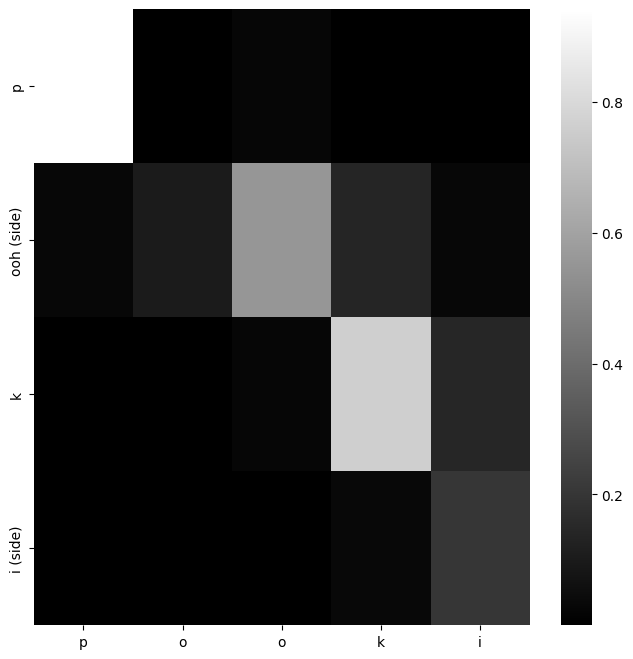

In [248]:
from seaborn import heatmap
import matplotlib.pyplot as plt

with wandb.init(project='CS6910-A3', name=f'heatmap_{test_eng[test_char]}'):
    fig, ax = plt.subplots(figsize=(8, 8))
    heatmap(word_attns.cpu(), xticklabels=list(test_eng[test_char]), yticklabels=[tam_to_eng_translit[tam_alphabet.letter_to_index[tam_letter]] for tam_letter in preds[0][:-3]], cmap='gray', ax=ax)
    plt.show()
    wandb.log({'attn_heatmap': wandb.Image(fig)})